In [ ]:
# usual imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# normalize/scale the values
# forecasting model for better results
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Reading the dataset
df = pd.read_csv('Housing_Prices.csv')

In [3]:
# Head of the dataset
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7229300521,20141013T000000,231300.0,2,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# Convert the date to datetime
df['Date'] = pd.to_datetime(df['date'])

# Keep only the Date and the price
df = df[['Date', 'price']]


In [5]:
df.head()

,Date,price
0,2014-10-13,231300.0
1,2014-12-09,538000.0
2,2015-02-25,180000.0
3,2014-12-09,604000.0
4,2015-02-18,510000.0


In [6]:
# Drop the Date --> replace with steps 
df = df.drop("Date", axis=1)

# Reset the index
df = df.reset_index(drop=True)
df.index = df.index * 0.1 + 1

In [7]:
# Save the Value column name
value_column = "price"

In [8]:
# Scaling values
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])
df.index = df.index * 0.1 + 1



In [9]:
df.head()   

,price
1.10,0.020498
1.11,0.060721
1.12,0.013770
1.13,0.069377
1.14,0.057049


In [10]:
df.describe()

,price
count,21613.000000
mean,0.060995
std,0.048148
min,0.000000
25%,0.032387
50%,0.049180
75%,0.074754
max,1.000000


In [ ]:
# The dataset was too large for this model, The model is not best fit over this huge dataset after spent time 
# So, making small dataset as the original dataset is too large
df = df.iloc[int(len(df)/2):]


In [12]:
df.shape

(10807, 1)

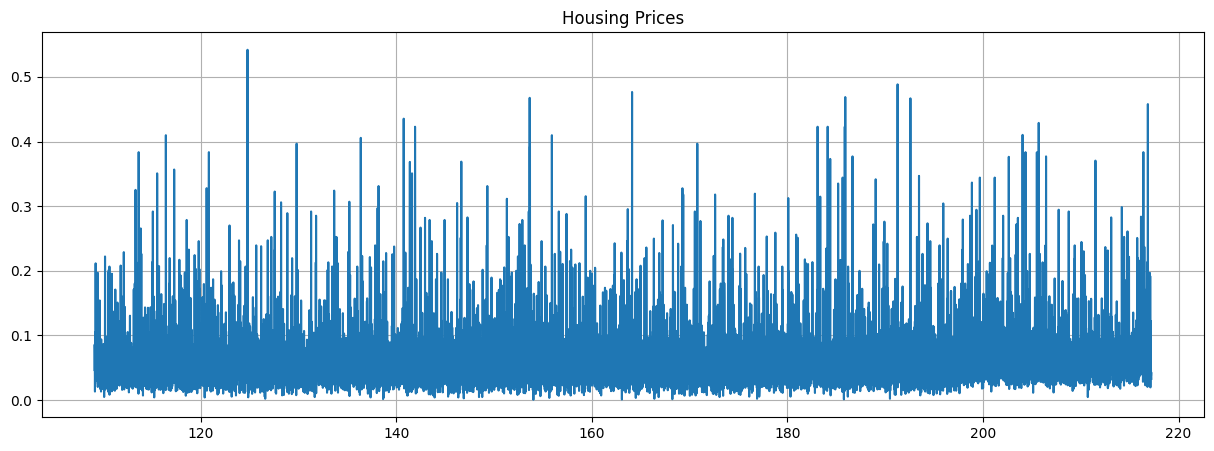

In [13]:
# Plot the data
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[value_column])
plt.title('Housing Prices')
plt.grid(True)
plt.show()

In [14]:
# Train test split
cutoff = int(len(df) * 0.8)

# Training data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]

# Testing data 
X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# Convert To NumPy -array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# We have one feature here
n_features = 1

# Reshaping data for futire use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

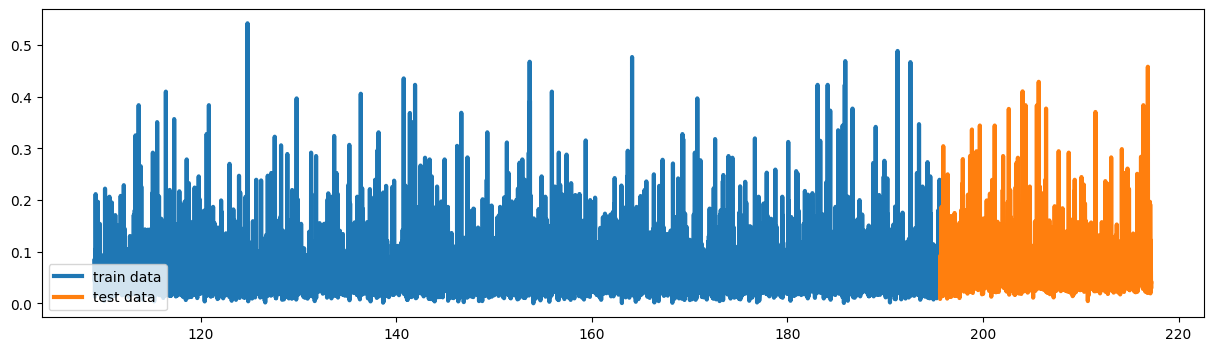

In [15]:
# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train, y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [16]:
# Time series generators
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

look_back  = 32
batch_size = 32

window_size = 5

# Creating generator training and testing data
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [17]:
#  Neural network model
from keras.models import Sequential
from keras import Input
from keras.layers import SimpleRNN, LSTM
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(LSTM(32, activation="relu", return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

# create a model checkpoint to save the best model
mc = ModelCheckpoint('best_model_sales.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

model.fit(train_generator, epochs=200, verbose=1, validation_data=test_generator, callbacks=callback_list)


Epoch 1/200

54/54 [==============================] - 4s 20ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 2/200
54/54 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 3/200
54/54 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/200
54/54 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/200
54/54 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/200
54/54 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/200
54/54 [==============================] - 1s 14ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/200
54/54 [==============================] - 1s 14ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/200
54/54 [==============================] - 1s 17ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/200
54/54 [==============================] - 1s 14ms/step - loss: 0.0024 - val_loss: 0.00

<Axes: >

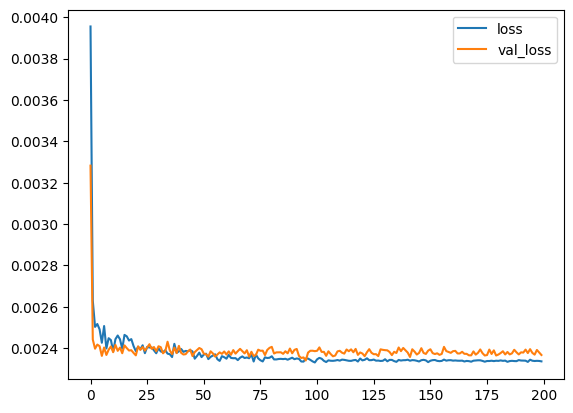

In [18]:
#  Training metrics
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [19]:
# reload the best version
from keras.models import load_model
model = load_model("best_model_flights.keras")

In [20]:
test_predictions = model.predict(test_generator)

14/14 [==============================] - 0s 2ms/step


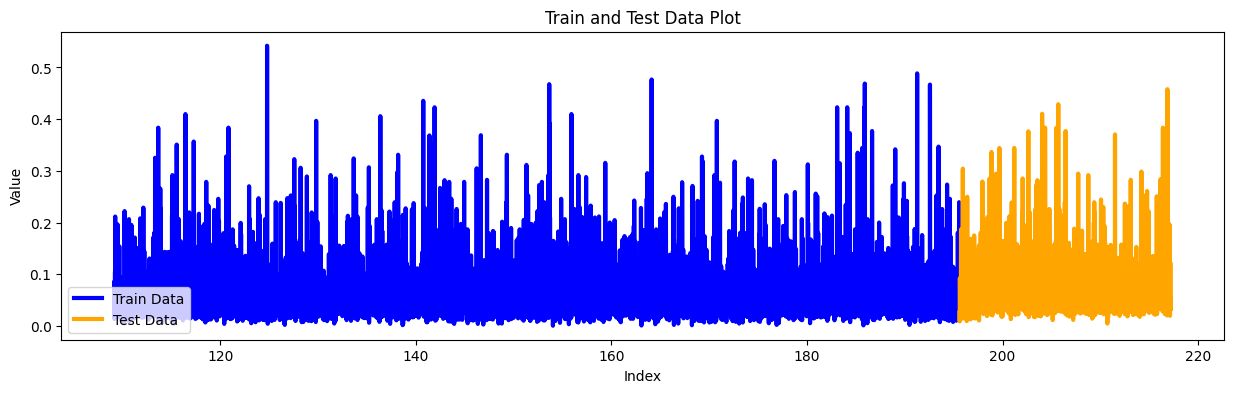

In [23]:
# Verify lengths
assert len(X_train) == len(y_train), "Mismatch in lengths of X_train and y_train"
assert len(X_test) == len(y_test), "Mismatch in lengths of X_test and y_test"

# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

# Plot train data
ax.plot(X_train, y_train, lw=3, label='Train Data', color='blue')

# Plot test data
ax.plot(X_test, y_test, lw=3, label='Test Data', color='orange')

# Add legend and labels
ax.legend(loc="lower left")
ax.set_title("Train and Test Data Plot")
ax.set_xlabel("Index")
ax.set_ylabel("Value")

plt.show()



In [24]:
 # TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

54/54 [==============================] - 0s 2ms/step - loss: 0.0023
Training loss: 0.002349250949919224
14/14 [==============================] - 0s 2ms/step - loss: 0.0023
Testing loss: 0.0023189757484942675


In [25]:
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
53.23 %

MAE
0.03 units

MSE
0.0 units^2

RMSE:
0.05 units

R-squared:
-0.0


In [32]:
# EXTRAPOLATION TEST 1 - 50 new points
extrapolation = []
look_back = 20

# Ensure the seed batch has the correct shape: (1, look_back, n_features)
seed_batch = y_test[:look_back].reshape((1, look_back, n_features))
current_batch = seed_batch.copy()

# Extrapolate the next 50 values
for i in range(50):
    # Predict the next value using the model
    predicted_value = model.predict(current_batch, verbose=0)[0]

    # Store the predicted value
    extrapolation.append(predicted_value)

    # Update the batch: Remove the oldest value and append the new prediction
    current_batch = np.append(current_batch[:, 1:, :], [[predicted_value]], axis=1)

# Convert the extrapolated values to a NumPy array
extrapolation = np.array(extrapolation)



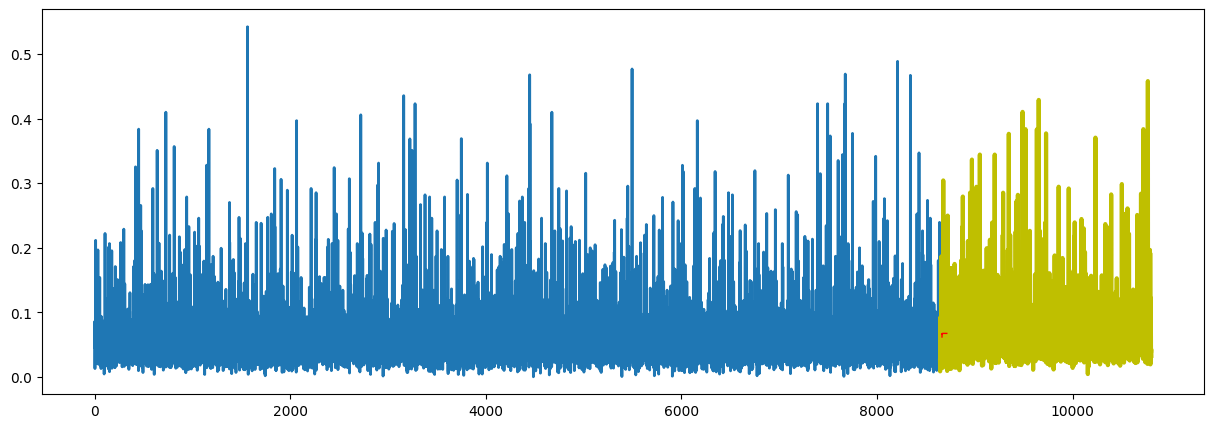

In [33]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')

plt.show()